## Functionality 3: explaining and visualizing


In [1]:
from func_modules import ControllerGraph
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
edges = pd.read_csv('./data/edges.csv')
controller = ControllerGraph(edges)
with open('./graphs.pickle', 'rb') as file:
    hero_graph, hero_comics_graph = pickle.load(file)

In [3]:
controller.functionality(3, hero_comics_graph, 400,
                         seq = ['ABOMINATION/EMIL BLO', 'ANCIENT ONE', 'IRON MAN/TONY STARK', 'SPIDER-MAN/PETER PARKER'],
                         endpoints=('CAPTAIN AMERICA', 'CAPTAIN MARVEL/CAPTA'))

['CAPTAIN AMERICA',
 'H2 278',
 'ABOMINATION/EMIL BLO',
 'ASM 23',
 'JAMESON, J. JONAH',
 'UTSM:SE',
 'ANCIENT ONE',
 'AF 6/2',
 'DR. STRANGE/STEPHEN',
 'A 115',
 'IRON MAN/TONY STARK',
 'A 11',
 'SPIDER-MAN/PETER PARKER',
 'A 168',
 'CAPTAIN MARVEL/CAPTA']

In [4]:
num_edges_lost, edges_lost, cut_graph = controller.functionality(4, hero_graph, 35,
                                                                 hero_2='SPIDER-MAN/PETER PARKER', hero_1='IRON MAN/TONY STARK')

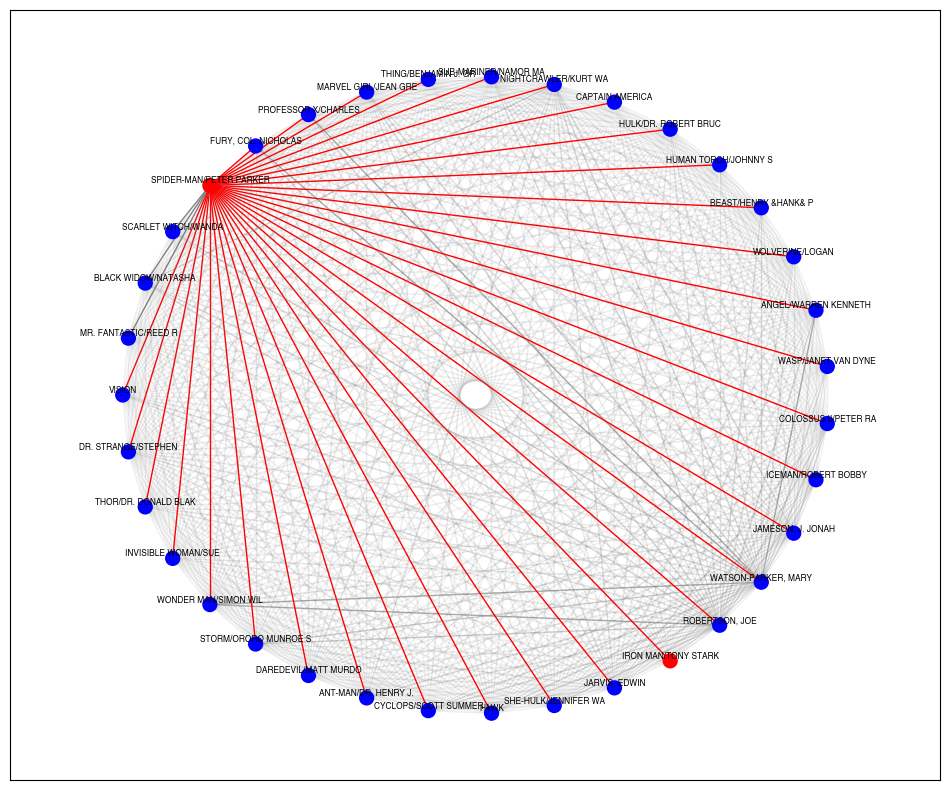

In [5]:
plt.gcf().set_size_inches((12, 10))
plot_graph = cut_graph.copy()
plot_graph.add_edges_from(edges_lost)
dict_pos = nx.shell_layout(plot_graph, scale= 0.1)
color_node = ['red' if node == 'SPIDER-MAN/PETER PARKER' or node == 'IRON MAN/TONY STARK' else 'blue' for node in plot_graph.nodes]
nx.draw_networkx_nodes(plot_graph, pos = dict_pos, node_size = 100, node_color=color_node)
nx.draw_networkx_labels(plot_graph, pos = dict_pos, font_size=6, font_family='helvetica', verticalalignment='bottom', font_weight='heavy')
color_edges = ['red' if (edge in edges_lost or reversed(edge) in edges_lost) else 'gray' for edge in plot_graph.edges]
alpha_edges = [x[2]/1.5 if x[2] else 1 for x in plot_graph.edges(data='weight')]
nx.draw_networkx_edges(plot_graph, pos = dict_pos, alpha = alpha_edges, edge_color = color_edges)
plt.margins(x=0.10)
plt.show()

In [6]:
('IRON MAN/TONY STARK', 'SPIDER-MAN/PETER PARKER') in edges_lost

True

In [7]:
nx.density(plot_graph)

1.0

In [8]:
alpha_edges

[0.2793731894642701,
 0.19130115485510135,
 0.19130115485510135,
 0.1437529446797382,
 0.1472853660332769,
 0.14634812920281964,
 0.14218038087580728,
 0.14826321485140384,
 0.1503537642130108,
 0.1503537642130108,
 0.11936804810640685,
 0.1212163159505542,
 0.12073382697729933,
 0.1317407715643222,
 0.12736971746392914,
 0.10745743844141258,
 0.09792196148182875,
 0.09462968968077896,
 0.09587851806928786,
 0.1029368360249388,
 0.10383350713643454,
 0.10197836601840332,
 0.10191710853174628,
 0.10203993927147766,
 0.11872704506824987,
 0.11167295076280122,
 0.11519094908396364,
 0.11851909134426873,
 0.1393478765850394,
 0.13806506052642467,
 0.14143555189828563,
 0.13219510000201298,
 0.2554828622248367,
 1,
 0.2554828622248367,
 0.19619988644253494,
 0.179789007837192,
 0.19619988644253494,
 0.14634812920281964,
 0.14826321485140384,
 0.14634812920281964,
 0.16120604499911798,
 0.14143555189828563,
 0.15801997838784307,
 0.15147393058179395,
 0.14928483931365263,
 0.1207338269772993

In [9]:
nx.density(plot_graph)

1.0

In [10]:
nx.density(plot_graph)

1.0